## Training

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Load dataset
file_path = "./POCl_doping_data.xlsx"
data = pd.read_excel(file_path)

# Define features and target
X = data.iloc[:, 0:10]
y = data.iloc[:, 10]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Metric functions
def mape_score(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define 5-Fold Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
print("=== Optimizing Random Forest ===")
rf_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    search_spaces={
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
    },
    n_iter=50,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs={"base_estimator": "GP", "acq_func": "EI"}
)
rf_search.fit(X_train, y_train)

# Gradient Boosting
print("=== Optimizing Gradient Boosting ===")
gbr_search = BayesSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    search_spaces={
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'subsample': Real(0.5, 1.0)
    },
    n_iter=50,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs={"base_estimator": "GP", "acq_func": "EI"}
)
gbr_search.fit(X_train, y_train)

# XGBoost
print("=== Optimizing XGBoost ===")
xgb_search = BayesSearchCV(
    estimator=XGBRegressor(tree_method='hist', random_state=42),
    search_spaces={
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'colsample_bytree': Real(0.3, 1.0),
        'subsample': Real(0.5, 1.0)
    },
    n_iter=50,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs={"base_estimator": "GP", "acq_func": "EI"}
)
xgb_search.fit(X_train, y_train)

# Final models and best parameters
models = {
    "RandomForest": rf_search.best_estimator_,
    "GradientBoosting": gbr_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
    "LinearRegression": LinearRegression()
}

best_params = {
    "RandomForest": rf_search.best_params_,
    "GradientBoosting": gbr_search.best_params_,
    "XGBoost": xgb_search.best_params_
}

# Evaluation
performance = []
final_gbr_model = None

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Model": name,
        "R2_Train": r2_score(y_train, y_train_pred),
        "R2_Test": r2_score(y_test, y_test_pred),
        "MAPE_Train": mape_score(y_train, y_train_pred),
        "MAPE_Test": mape_score(y_test, y_test_pred),
        "RMSE_Train": rmse_score(y_train, y_train_pred),
        "RMSE_Test": rmse_score(y_test, y_test_pred)
    }

    performance.append(metrics)

    if name == "GradientBoosting":
        final_gbr_model = model
        gbr_train_df = pd.DataFrame({"Actual": y_train, "Predicted": y_train_pred})
        gbr_test_df = pd.DataFrame({"Actual": y_test, "Predicted": y_test_pred})

# Save Excel output
output_path = "machine_learning_training_results_POCl3_CV_BO.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    pd.DataFrame(performance).to_excel(writer, index=False, sheet_name="Performance Metrics")
    gbr_train_df.to_excel(writer, index=False, sheet_name="GBR Train Predictions")
    gbr_test_df.to_excel(writer, index=False, sheet_name="GBR Test Predictions")
    pd.DataFrame.from_dict(best_params, orient='index').to_excel(writer, sheet_name="Best Params")

# Save models
os.makedirs("trained_models", exist_ok=True)
for name, model in models.items():
    path = f"trained_models/{name}_model.pkl"
    joblib.dump(model, path)
    print(f"{name} model saved to {path}")

=== Optimizing Random Forest ===
=== Optimizing Gradient Boosting ===
=== Optimizing XGBoost ===
RandomForest model saved to trained_models/RandomForest_model.pkl
GradientBoosting model saved to trained_models/GradientBoosting_model.pkl
XGBoost model saved to trained_models/XGBoost_model.pkl
LinearRegression model saved to trained_models/LinearRegression_model.pkl


In [16]:
# Save GBR Bayesian Optimization trial results
gbr_cv_results = pd.DataFrame(gbr_search.cv_results_)
gbr_cv_results.to_excel("gbr_bayesopt_trials.xlsx", index=False, engine="openpyxl")
print("Gradient Boosting trial log saved to 'gbr_bayesopt_trials.xlsx'")

Gradient Boosting trial log saved to 'gbr_bayesopt_trials.xlsx'


         Feature  Importance
4          POCL3    0.281016
0   pre-dep temp    0.255093
3       time (2)    0.192859
2  Drive-in temp    0.106337
6           torr    0.092597
9       Location    0.020615
7           Boat    0.020522
1           time    0.016820
8           Slot    0.007874
5             O2    0.006266


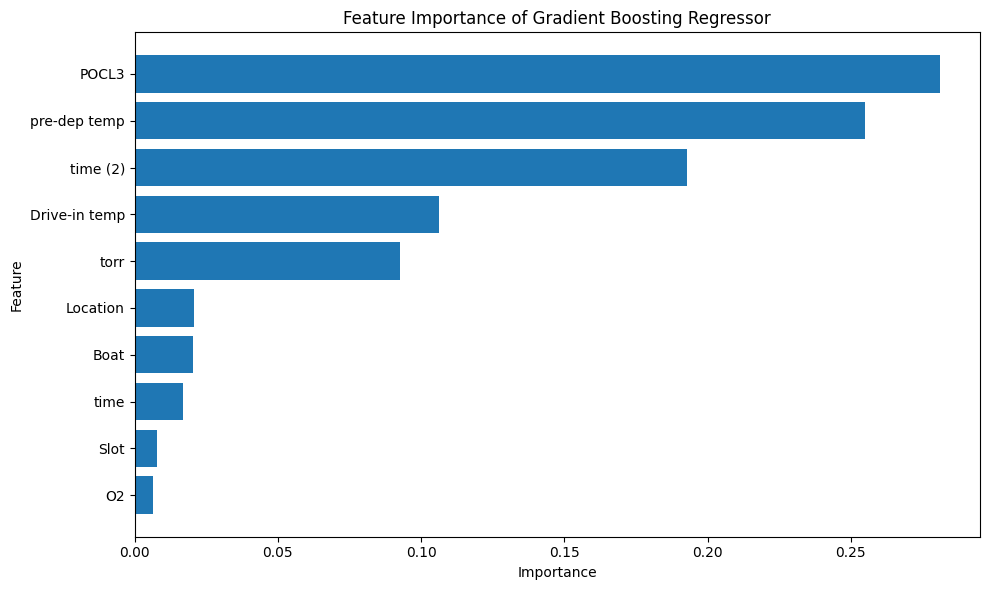

In [2]:
import matplotlib.pyplot as plt

# Extract feature importance from the trained GBR model
importances = final_gbr_model.feature_importances_
features = X_train.columns

# Create a sorted DataFrame of feature importances
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display ranked feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], align="center")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance of Gradient Boosting Regressor")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Bayesian Optimization

In [ ]:
# Optimization Using Bayesian Optimization

import pandas as pd
import numpy as np
from bayes_opt import BayesianOptimization

# Ensure final_gbr_model is available
try:
    final_gbr_model
except NameError:
    raise NameError("final_gbr_model is not defined. Please run the training code first.")

# Load dataset
file_path = "./POCl_doping_data.xlsx"
data = pd.read_excel(file_path)

print("Dataset columns:", data.columns.tolist())
print(data.head())

# Define objective function for Bayesian optimization
def objective_function(pre_dep_temp, time, drive_in_temp, time_2, POCL3, O2, torr, boat, slot, location):
    boat = int(round(boat))
    slot = int(round(slot))
    location = int(round(location))

    input_data = pd.DataFrame({
        'pre-dep temp': [pre_dep_temp],
        'time': [time],
        'Drive-in temp': [drive_in_temp],
        'time (2)': [time_2],
        'POCL3': [POCL3],
        'O2': [O2],
        'torr': [torr],
        'Boat': [boat],
        'Slot': [slot],
        'Location': [location]
    })

    try:
        input_data = input_data[final_gbr_model.feature_names_in_]
    except AttributeError:
        pass

    prediction = final_gbr_model.predict(input_data)[0]
    return -abs(prediction - 150)


# Define search space
pbounds = {
    'pre_dep_temp': (700, 920),
    'drive_in_temp': (800, 900),
    'time': (5, 20),
    'time_2': (5, 20),
    'POCL3': (0.1, 0.5),
    'O2': (0.5, 2.0),
    'torr': (10, 100),
    'boat': (1, 8),
    'slot': (20, 80),
    'location': (1, 9)
}

# Run Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(init_points=100, n_iter=100)

# Post-process results
results = []
for res in optimizer.res:
    params = res["params"]
    params["boat"] = int(round(params["boat"]))
    params["slot"] = int(round(params["slot"]))
    params["location"] = int(round(params["location"]))
    params["target"] = -res["target"]
    results.append(params)

results_df = pd.DataFrame(results)

# Extract best result
best = optimizer.max["params"]
best["boat"] = int(round(best["boat"]))
best["slot"] = int(round(best["slot"]))
best["location"] = int(round(best["location"]))
best["target"] = -optimizer.max["target"]
best_df = pd.DataFrame([best])

# Save results
output_path = "./optimization_results.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    results_df.to_excel(writer, index=False, sheet_name="All Results")
    best_df.to_excel(writer, index=False, sheet_name="Best Result")

print(f"Results saved to '{output_path}'")

Dataset columns: ['pre-dep temp', 'time', 'Drive-in temp', 'time (2)', 'POCL3', 'O2', 'torr', 'Boat', 'Slot', 'Location', 'Sheet resistance']
   pre-dep temp  time  Drive-in temp  time (2)  POCL3  O2  torr  Boat  Slot  \
0           750     9            820        17    0.3   1    50     1    60   
1           750     9            820        17    0.3   1    50     1    80   
2           750     9            820        17    0.3   1    50     1    20   
3           750     9            820        17    0.3   1    50     1    60   
4           750     9            820        17    0.3   1    50     1    60   

   Location  Sheet resistance  
0         3             261.4  
1         7             261.2  
2         9             260.7  
3         7             259.9  
4         9             259.4  
|   iter    |  target   |    O2     |   POCL3   |   boat    | drive_... | location  | pre_de... |   slot    |   time    |  time_2   |   torr    |
---------------------------------------------

In [ ]:
# Comparison Between Bayesian Optimization and Random Search for Parameter Optimization

import pandas as pd
import numpy as np

# Define the parameter ranges
parameter_space = {
    'pre-dep temp': (700, 920),
    'time': (5, 20),
    'Drive-in temp': (800, 900),
    'time (2)': (5, 20),
    'POCL3': (0.1, 0.5),
    'O2': (0.5, 2.0),
    'torr': (10, 100),
    'Boat': (1, 9),
    'Slot': (20, 80),
    'Location': (1, 9)
}

# Sampling configuration
n_trials = 1000
target_value = 150
threshold = 0.1259
deviation_limit = 20

# Generate random samples
np.random.seed(42)
samples = []
for _ in range(n_trials):
    sample = {
        key: np.random.uniform(*value) if key not in ['Boat', 'Slot', 'Location']
        else int(np.random.randint(value[0], value[1] + 1))
        for key, value in parameter_space.items()
    }
    samples.append(sample)

# Evaluate each sample
results = []
for idx, sample in enumerate(samples, 1):
    input_df = pd.DataFrame([sample])
    try:
        input_df = input_df[final_gbr_model.feature_names_in_]
    except AttributeError:
        pass
    prediction = final_gbr_model.predict(input_df)[0]
    abs_error = abs(prediction - target_value)
    results.append({
        **sample,
        "Prediction": prediction,
        "Absolute Error": abs_error,
        "Trial": idx
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Count how many points met each condition
within_20_count = (results_df["Absolute Error"] < deviation_limit).sum()
within_threshold_count = (results_df["Absolute Error"] <= threshold).sum()

# Save results to Excel
with pd.ExcelWriter("random_search_results.xlsx", engine="openpyxl") as writer:
    results_df.to_excel(writer, index=False, sheet_name="All Results")

# Print summary
print(f"✅ Total trials: {n_trials}")
print(f"✅ Points with deviation < {deviation_limit}: {within_20_count}")
print(f"✅ Points with error ≤ {threshold}: {within_threshold_count}")

✅ Total trials: 1000
✅ Points with deviation < 20: 116
✅ Points with error ≤ 0.1259: 1


## SHAP analysis

/home/user/Research/250221_POCl_doping/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


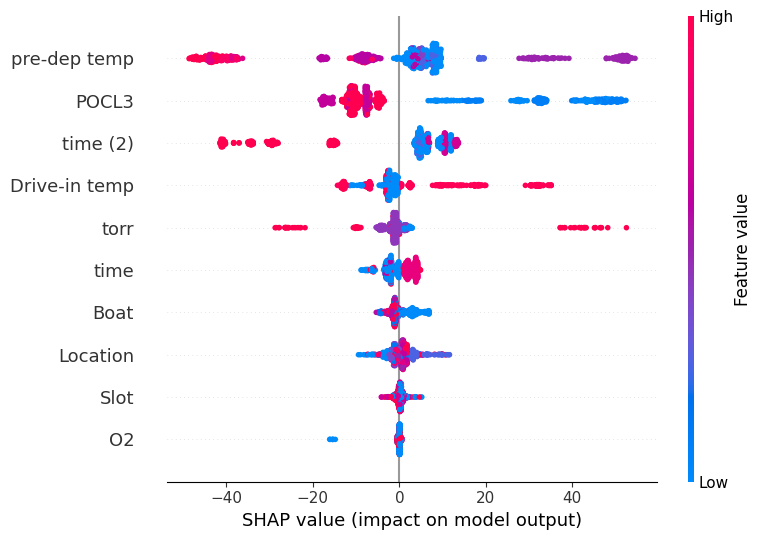

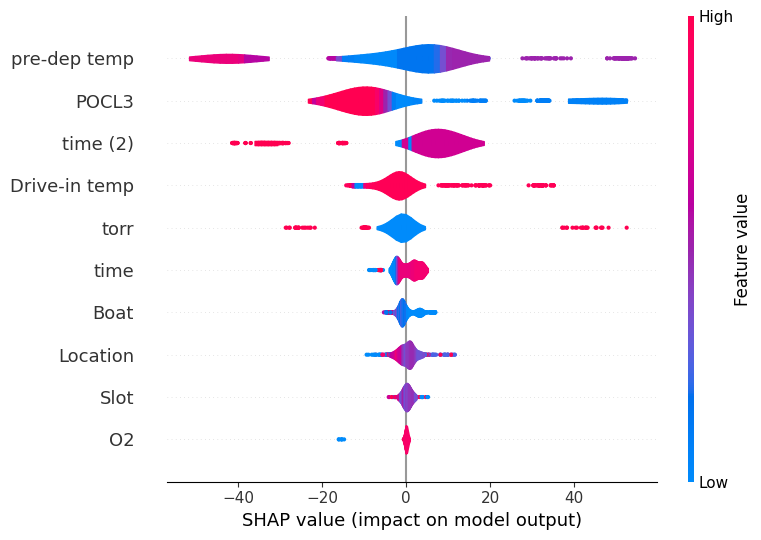

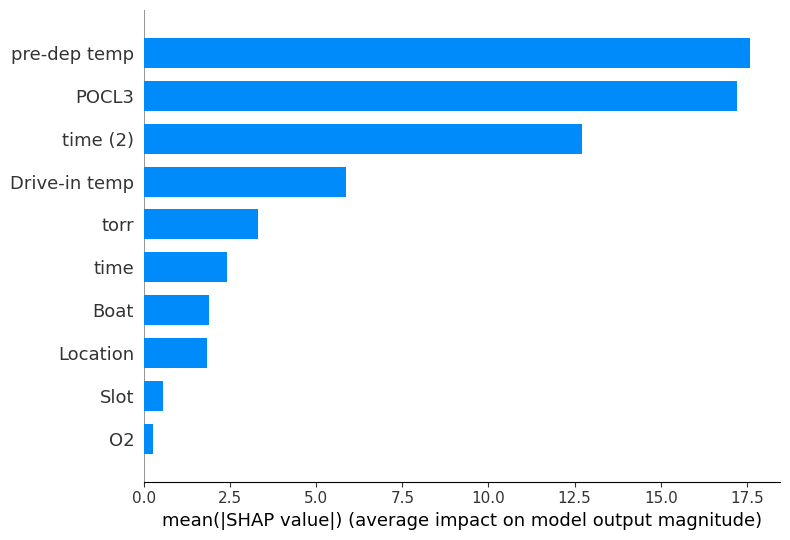

In [5]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer and compute SHAP values
explainer = shap.Explainer(final_gbr_model, X_train)
shap_values = explainer(X_train)

# Plot feature importance summary
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="violin")
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [14]:
import shap
import pandas as pd

# Extract input feature values and SHAP values from the explanation object
X_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

# Define the subset of features to include
selected_features = [
    "pre-dep temp", "time", "Drive-in temp", "time (2)",
    "POCL3", "O2", "torr", "Boat", "Slot", "Location"
]

# Define output file path
output_file = "shap_dependence_all_features.xlsx"

# Initialize Excel writer
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for feature in selected_features:
        if feature not in X_df.columns:
            print(f"Feature '{feature}' not found. Skipping.")
            continue

        # Construct the dependence data
        dependence_data = pd.DataFrame({
            "Feature value": X_df[feature],
            "SHAP value": shap_df[feature]
        }).dropna()

        # Sanitize sheet name to comply with Excel limitations
        sheet_name = feature.replace(" ", "_").replace("(", "").replace(")", "")[:31]

        # Export to individual sheet
        dependence_data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"SHAP dependence data successfully exported to '{output_file}'")

SHAP dependence data successfully exported to 'shap_dependence_all_features.xlsx'


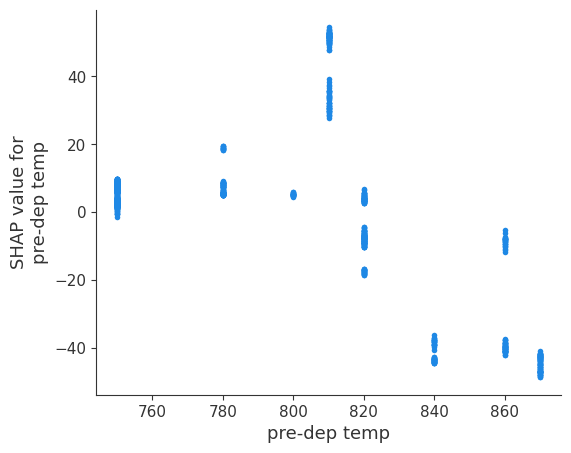

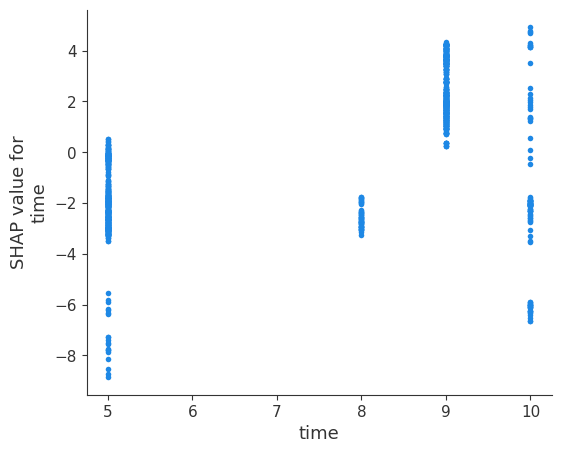

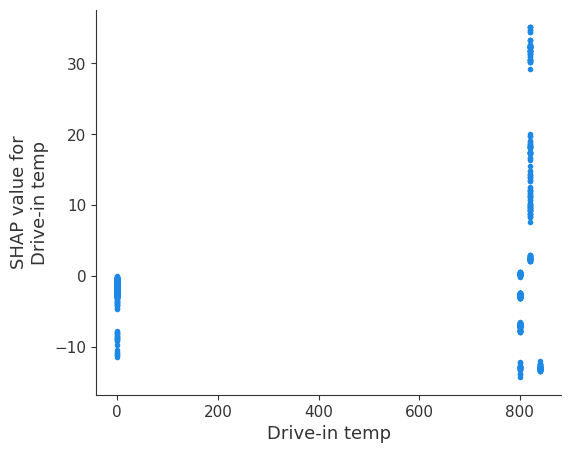

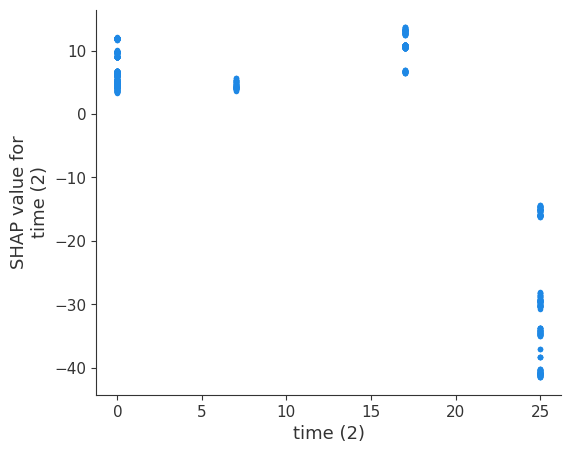

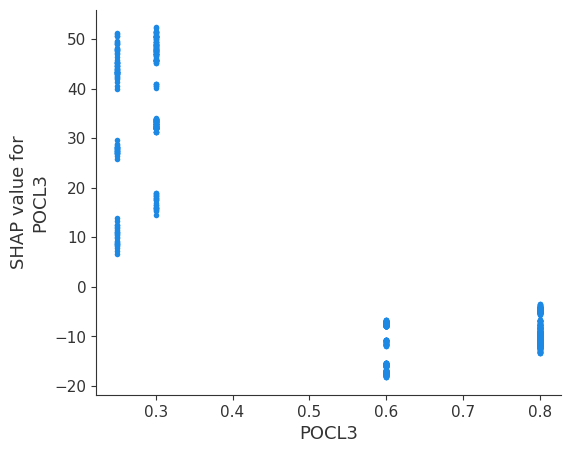

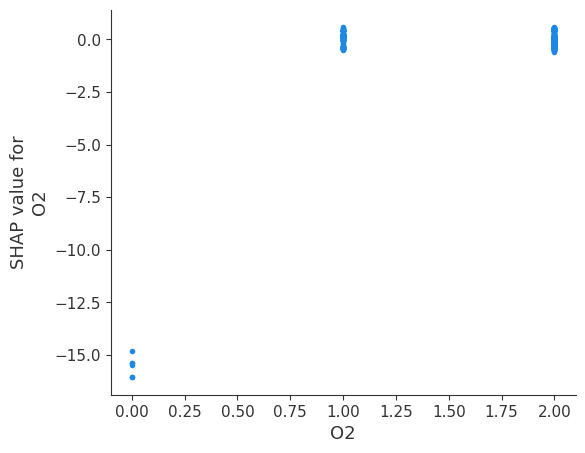

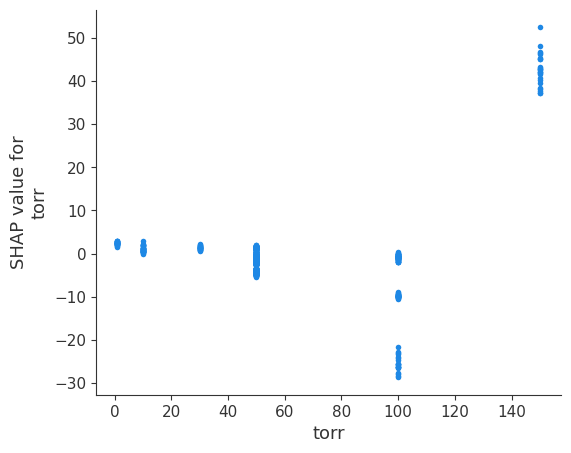

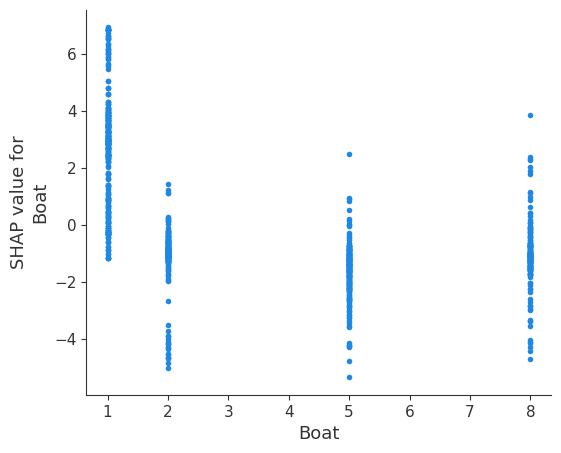

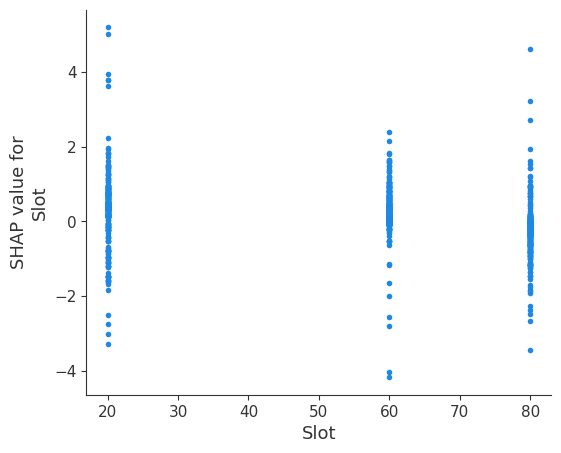

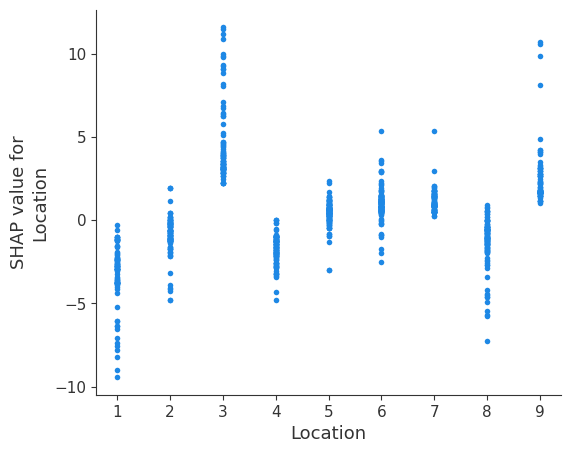

In [7]:
shap.dependence_plot("pre-dep temp", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("time", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("Drive-in temp", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("time (2)", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("POCL3", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("O2", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("torr", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("Boat", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("Slot", shap_values.values, X_train, interaction_index=None)
shap.dependence_plot("Location", shap_values.values, X_train, interaction_index=None)